# AI fairness by using modified loss functions

This project is based on work as discussed in a blogpost by [**GoDataDriven**](https://godatadriven.com/blog/towards-fairness-in-ml-with-adversarial-networks/). They used an adversarial architecture to guide their classifier towards fairer predictions, by having the adversarial try and predict sensitive attributes using only the output of the classifier model. The simplicity of the adversarial networks led me to believe that an easier, and more flexible approach, would be to directly modify the loss function manually. The adversarial network in the blog post is essentialy a dynamic black-box addition the binary cross-entropy loss function. We try a different approach where we manually change the loss function. By manually adding terms to the loss function we can experiment with precisely which metric we want to implement into the loss function, and hopefully gives a more explainable approach.

The code in this notebook is based on the code for the adversarial network fairness blogpost as shared on [**GoDataDriven Git**](https://github.com/equialgo/fairness-in-ml/blob/master/fairness-in-ml.ipynb)

The Fairness metrics as implemented in this notebook are referenced from [**Pessach et al. 2020**](https://arxiv.org/pdf/2001.09784.pdf) 

### *Conclusions*

### General 
In general, fairness based additions to the loss function are not convex. Because of this their behaviour can change very dramatically with small changes in their scaling. The best performance is reached by taking weights from a pretrained network and using those as a best-estimate starting point for these unstable loss functions.

Below we demonstrate some cases where our manual tweaking achieve results better than the results shown by Adversarial Fairness network. However, for an unbiased comparisson we would need to use an aditional validation which was not done.

### Trade-off
We observe a trade-off between different types of fairness. Per definition, if you are increasing the Disparate Impact Fairness you are decreasing the Equal Odds Fairness. Disparate impact equalizes the total positive rate without taking into account the actual positive rates in the classes being equalized. The True Positive Rates and False Positive Rates get affected differently per subclass.

### Disparate impact
We also notice that adding Disparate Impact or Demographic Parity to the loss function brings the positive rate to to a value inbetween the base rates of both classes, closer to the lowest rate than the highest. This means the false positives for the lower class are increased and the false negatives for the higher class are increased.

### Equalized odds
Meanwhile adding equal odds means that the TPR and FPR are equalized. In practice this added term to the loss function turns out to be even more unstable than Disparate Impact. Most of the time, it forces all prediction scores below the 0.5 boundary. This is a problem more often encountered where a NN chooses for the trivial solution at hand if allowed; TPR and FPR are nicely equalized when there are 0 positive predictions for any class. This is also a trivial solution for Disparate impact, so what makes it so that it doesn't happen there but does happen here is not clear to me.

Equalized odds can also be optimized after training is completed, by finding itersection points in the ROC-curves. However, we cannot optimize this for two protected attributes at the same time. Thus we can only perform this optimization for a single protected class, making this less desirable.
Using this method we do demonstrate that for a single class both fairness metrics can be optimized to high values: 
  
*These values vary slightly per run*  
  P-rule: 79% (baseline: 53%)  
  EO-fairness: 1% (baseline: 9%)  
  This does come at a cost however:  
  AUC_ROC: 78% (baseline: 92%)  
  Accuracy: 78% (baseline: 86%)  

In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

In [3]:
# HIDE
import pandas as pd
import numpy as np
np.random.seed(94)
import matplotlib.pyplot as plt
plt.style.use("seaborn-darkgrid")
import seaborn as sns
from IPython import display
%matplotlib inline

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight


create_gif = False

print(f"sklearn: {sk.__version__}")
print(f"pandas: {pd.__version__}")
print(f"tensorflow: {tf.__version__}")

sklearn: 0.24.1
pandas: 1.2.3
tensorflow: 2.4.1


# Baseline performance of a NN with binary cross-entropy loss
First we measure the base performance on our loss, accuracy and fairness measures for off-the-shelf implementation of a classifier network

## Loading and preprocessing of the data

In [4]:
def load_UCI_data(path):
    """
    Load the ADULT UCI dataset and split of the 2 sensitive attributes Z.
    
    Parameters
    ----------
    path - str
        The path to the UCI DATA csv
    
    Returns
    -------
    X - Dataframe
        The training attributes
    y - Dataframe
        The classification target
    Z - Dataframe
        The protected/sensitive attributes sex and race
    """
    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 
                    'marital_status', 'occupation', 'relationship', 'race', 'sex', 
                    'capital_gain', 'capital_loss', 'hours_per_week', 'country', 'target']
    input_data = (pd.read_csv(path, names=column_names, 
                              na_values="?", sep=r'\s*,\s*', engine='python')
                  .loc[lambda df: df['race'].isin(['White', 'Black'])])

    # sensitive attributes; we identify 'race' and 'sex' as sensitive attributes
    sensitive_attribs = ['race', 'sex']
    Z = (input_data.loc[:, sensitive_attribs]
         .assign(race=lambda df: (df['race'] == 'White').astype(int),
                 sex=lambda df: (df['sex'] == 'Male').astype(int)))

    # targets; 1 when someone makes over 50k , otherwise 0
    y = (input_data['target'] == '>50K').astype(int)

    # features; note that the 'target' and sentive attribute columns are dropped
    X = (input_data
         .drop(columns=['target', 'race', 'sex'])
         .fillna('Unknown')
         .pipe(pd.get_dummies, drop_first=True))
    
    print(f"features X: {X.shape[0]} samples, {X.shape[1]} attributes")
    print(f"targets y: {y.shape[0]} samples")
    print(f"sensitives Z: {Z.shape[0]} samples, {Z.shape[1]} attributes")
    return X, y, Z

In [5]:
X, y, Z = load_UCI_data('adult.data')
y = y.astype(np.float64)
Z = Z.astype(np.float64)

features X: 30940 samples, 94 attributes
targets y: 30940 samples
sensitives Z: 30940 samples, 2 attributes


In [6]:
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, y, Z, test_size=0.2, 
                                                                     stratify=y, random_state=94)

# standardize the data
scaler = StandardScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler)

In [7]:
protected_attributes = ["race", "sex"]
subclasses = [0,1]
print("Distribution of the protected attributes")
for protected in protected_attributes:
    for subclass in subclasses:
        counts = len(Z_test[Z_test[protected]==subclass])
        perc = counts/len(Z_test)*100
        print(f"{protected} == {subclass}: {perc:.1f}% -- {counts:.0f} samples")
print("\nNotice that race is very skewed towards class 1")

print("\nDistribution of target=1 over the protected attributes")
total_1 = y_test.sum()
for protected in protected_attributes:
    for subclass in subclasses:
        counts = y_test[Z_test[protected]==subclass].sum()
        perc = counts/total_1*100
        print(f"{protected} == {subclass}: {perc:.1f}% -- {counts:.0f} samples")
        
print("\nPositive rates for the protected attributes")
total_1 = y_test.sum()
for protected in protected_attributes:
    for subclass in subclasses:
        size_subclass = len(Z_test[Z_test[protected]==subclass])
        positives_subclass = y_test[Z_test[protected]==subclass].sum()
        pr = positives_subclass/size_subclass*100
        print(f"{protected} == {subclass}: {pr:.1f}%")

Distribution of the protected attributes
race == 0: 10.0% -- 619 samples
race == 1: 90.0% -- 5569 samples
sex == 0: 34.1% -- 2112 samples
sex == 1: 65.9% -- 4076 samples

Notice that race is very skewed towards class 1

Distribution of target=1 over the protected attributes
race == 0: 5.2% -- 78 samples
race == 1: 94.8% -- 1423 samples
sex == 0: 13.7% -- 206 samples
sex == 1: 86.3% -- 1295 samples

Positive rates for the protected attributes
race == 0: 12.6%
race == 1: 25.6%
sex == 0: 9.8%
sex == 1: 31.8%


## Base NN-model training

In [8]:
tf.random.set_seed(
    94
)

def nn_classifier(n_features):
    inputs = Input(shape=(n_features,))
    dense1 = Dense(32, activation='relu')(inputs)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(32, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    dense3 = Dense(32, activation="relu")(dropout2)
    dropout3 = Dropout(0.2)(dense3)
    outputs = Dense(1, activation='sigmoid')(dropout3)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# initialise NeuralNet Classifier
clf = nn_classifier(n_features=X_train.shape[1])

# train on train set
history = clf.fit(X_train.values, y_train.values, epochs=20, verbose=1)

Epoch 1/20
774/774 [==============================] - 80s 1ms/step - loss: 0.4998
Epoch 2/20
774/774 [==============================] - 1s 1ms/step - loss: 0.3551
Epoch 3/20
774/774 [==============================] - 1s 1ms/step - loss: 0.3353
Epoch 4/20
774/774 [==============================] - 1s 1ms/step - loss: 0.3253
Epoch 5/20
774/774 [==============================] - 1s 1ms/step - loss: 0.3201
Epoch 6/20
774/774 [==============================] - 1s 1ms/step - loss: 0.3210
Epoch 7/20
774/774 [==============================] - 1s 1ms/step - loss: 0.3206
Epoch 8/20
774/774 [==============================] - 1s 1ms/step - loss: 0.3183
Epoch 9/20
774/774 [==============================] - 1s 1ms/step - loss: 0.3117
Epoch 10/20
774/774 [==============================] - 1s 1ms/step - loss: 0.3134
Epoch 11/20
774/774 [==============================] - 1s 1ms/step - loss: 0.3201
Epoch 12/20
774/774 [==============================] - 1s 1ms/step - loss: 0.3119
Epoch 13/20
774/774 [===

# Performance and Fairness - BCE network


In [9]:
# predict on test set
y_pred = pd.Series(clf.predict(X_test.values).ravel(), index=y_test.index)
def score_report(y_pred,y_test,Z_test=Z_test):
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.2f}")
    print(f"Basline Accuracy: {100*np.max([len(y_test[y_test==0]),len(y_test[y_test==1])])/len(y_test):.1f}%")
    print(f"Accuracy: {100*accuracy_score(y_test, (y_pred>=0.5)):.1f}%")
    print(f"Precision: {100*precision_score(y_test, y_pred>=0.5):.1f}%")
    print(f"Recall: {100*recall_score(y_test, y_pred>=0.5):.1f}%")
    print(f"Classification reports per protected Attribute:")
    for z_att in ["race","sex"]:
        print(f"\n           Protected class == {z_att}")
        for subclass in [0,1]:
            print(f"                      Subclass=={subclass}\n")
            mask = Z_test[z_att] == subclass
            y_pred_sub = y_pred[mask]
            y_test_sub = y_test[mask]
            print(f"Accuracy: {100*accuracy_score(y_test_sub, y_pred_sub>=0.5):.1f}%")
            print(f"Precision: {100*precision_score(y_test_sub, y_pred_sub >= 0.5):.1f}%")
            print(f"Recall: {100*recall_score(y_test_sub, y_pred_sub >= 0.5):.1f}%")
            overlap = (y_pred_sub>=0.5)*y_test_sub
            print(f"Sampels: {len(y_pred_sub)} - Positives: {(y_pred_sub>=0.5).sum()} - Correct positives: {overlap.sum():.0f}")
            print(f"Positive rate: {(y_pred_sub>=0.5).sum()/len(y_pred_sub)*100:.1f}%")
score_report(y_pred, y_test)
        

ROC AUC: 0.92
Basline Accuracy: 75.7%
Accuracy: 85.9%
Precision: 76.7%
Recall: 60.0%
Classification reports per protected Attribute:

           Protected class == race
                      Subclass==0

Accuracy: 91.0%
Precision: 66.2%
Recall: 57.7%
Sampels: 619 - Positives: 68 - Correct positives: 45
Positive rate: 11.0%
                      Subclass==1

Accuracy: 85.3%
Precision: 77.3%
Recall: 60.1%
Sampels: 5569 - Positives: 1106 - Correct positives: 855
Positive rate: 19.9%

           Protected class == sex
                      Subclass==0

Accuracy: 93.7%
Precision: 72.7%
Recall: 56.8%
Sampels: 2112 - Positives: 161 - Correct positives: 117
Positive rate: 7.6%
                      Subclass==1

Accuracy: 81.8%
Precision: 77.3%
Recall: 60.5%
Sampels: 4076 - Positives: 1013 - Correct positives: 783
Positive rate: 24.9%


In [10]:
def plot_distributions(y, Z, iteration=None, val_metrics=None, p_rules=None, fname=None):
    """
    Creates kernel Density estimate plots of the NN-prediction scores 
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    legend={'race': ['black','white'],
            'sex': ['female','male']}
    for idx, attr in enumerate(Z.columns):
        for attr_val in [0, 1]:
            ax = sns.kdeplot(data=y[Z[attr] == attr_val],
                             label='{}'.format(legend[attr][attr_val]), 
                             ax=axes[idx], fill=True)
        ax.set_xlim(0,1)
        ax.set_ylim(0,7)
        ax.set_yticks([])
        ax.set_title("sensitive attibute: {}".format(attr))
        if idx == 0:
            ax.set_ylabel('prediction distribution')
        ax.set_xlabel(r'$P({{income>50K}}|z_{{{}}})$'.format(attr))
    if iteration:
        fig.text(1.0, 0.9, f"Training iteration #{iteration}", fontsize='16')
    if val_metrics is not None:
        fig.text(1.0, 0.65, '\n'.join(["Prediction performance:",
                                       f"- ROC AUC: {val_metrics['ROC AUC']:.2f}",
                                       f"- Accuracy: {val_metrics['Accuracy']:.1f}"]),
                 fontsize='16')
    if p_rules is not None:
        fig.text(1.0, 0.4, '\n'.join(["Satisfied p%-rules:"] +
                                     [f"- {attr}: {p_rules[attr]:.0f}%-rule" 
                                      for attr in p_rules.keys()]), 
                 fontsize='16')
    fig.tight_layout()
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight',  dpi = 300)
    return fig

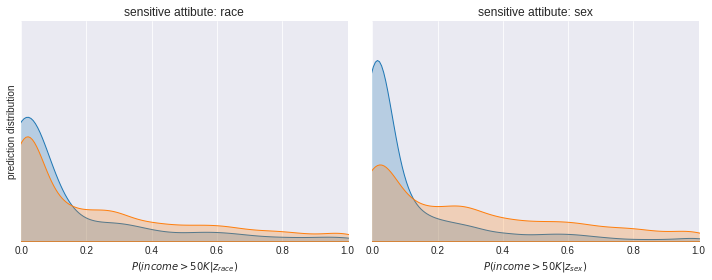

In [11]:
fig = plot_distributions(y_pred, Z_test)

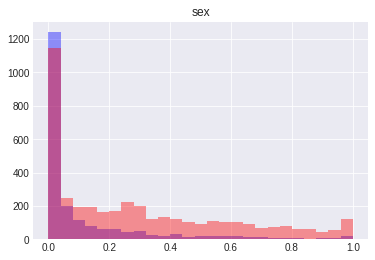

0.11115101454480159
0.5181550539744848


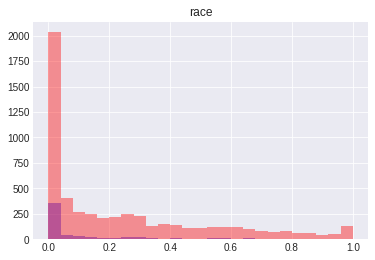

In [12]:
title="sex"
plt.title(title)
plt.hist(y_pred[Z_test[title]==0],25,(0,1),alpha=0.4,color="b")
plt.hist(y_pred[Z_test[title]==1],25,(0,1),alpha=0.4,color="r")
plt.show()
title="race"
plt.title(title)
plt.hist(y_pred[Z_test[title]==0],25,(0,1),alpha=0.4,color="b")
plt.hist(y_pred[Z_test[title]==1],25,(0,1),alpha=0.4,color="r")
print(len(y_pred[Z_test["race"]==0])/len(y_pred[Z_test["race"]==1]))
print(len(y_pred[Z_test["sex"]==0])/len(y_pred[Z_test["sex"]==1]))

## P%-rule (Disparate Impact (DI) metric)
This metric is one way to measure the fairness of an algorithm. The 80%-rule, als known as the rule of Four-Fifths states that the selection rate for any group (classified by race, orientation or ethnicity) that is less than four-fifths of that for the group with the highest rate constitutes evidence of adverse impact (also called ‘Disparate impact’. This Four-Fifths rule has been stated in US hiring procedures for the state of California. Any group (based on sex, race, etc.) which has a hiring rate of less than 80% of the most succesfull group is said to have undergone adverse impact. This rule has been critzised based on the arbitrary nature of the rule, and should not be taken as a gold standard. However, it provides a standard which can be used as a basis for this project.

In [Zafar et al. 2017](https://arxiv.org/pdf/1507.05259.pdf) it is stated that the Disparate Impact measure is non-convex when implemented in algorithms. However, this need not necessarily be a problem as most NN loss functions are in fact non-convex. This notebook does not provide a rigorous derivation of why this works. However, it is empirically shown to obtain the sought-after effects.  

This P%-rule is can give a false sense of fairness when the base positive rates for the two groups are in fact very different for a good reason. If you assume there is an unwanted bias in the way the labels are assigned, or you assume there is a bias in the way the data is acquired, this is a usefull fairness metric.  

In [13]:
def p_rule(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1] > threshold if threshold else y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0] > threshold if threshold else y_pred[z_values == 0]
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1/odds]) * 100

In [14]:
print("The classifier satisfies the following %p-rules:")
print(f"\tgiven attribute race; {p_rule(y_pred, Z_test['race']):.0f}%-rule")
print(f"\tgiven attribute sex;  {p_rule(y_pred, Z_test['sex']):.0f}%-rule")
        

The classifier satisfies the following %p-rules:
	given attribute race; 55%-rule
	given attribute sex;  31%-rule


It is clear that the current performance is very much biased, especially if one considers the sex of the person in question. 

## Demographic parity
This is very similair to the p-rule, it measures the difference between P(Y=1|Z=0) and (P(Y=1|Z=1).
In essense there is no real difference between this metric and disparate impact. Both metrics aim to achieve P(Y=1|Z=0) = (P(Y=1|Z=1) in a perfect scenario. Disparate impact does this by considering the ratio between the two values, while Demographic parity does this by considering the absolute difference between the two values.

In [15]:
def demographic_parity(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1] > threshold if threshold else y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0] > threshold if threshold else y_pred[z_values == 0]
    parity = np.abs(y_z_1.mean() - y_z_0.mean())
    return parity * 100

In [16]:
print("The classifier sattisfies the following Demographic parities:")
print(f"\tgiven attribute race; {demographic_parity(y_pred, Z_test['race']):.1f}%")
print(f"\tgiven attribute sex;  {demographic_parity(y_pred, Z_test['sex']):.1f}%")

The classifier sattisfies the following Demographic parities:
	given attribute race; 8.9%
	given attribute sex;  17.2%


One disadvantage of these two measures is that a fully accurate classifier may be considered
unfair, when the base rates (i.e., the proportion of actual positive outcomes) of the various
groups are significantly different. ([**Pessach et al. 2020**](https://arxiv.org/pdf/2001.09784.pdf))

##  Equalized odds
Equalized odds looks at the difference in false positive rates and true positive rates for the groups in question.
The goal for for equalized odds is to grant both groups the same false positive rate and true positive rate; Your odds of getting assigned a 1 are the same regardless of which group you are in. This fairness metric works well, but implies that you assume your dataset is not biased and that the base rates of the groups in your dataset are representative. This may of course be problematic to use in scenarios where 

In [17]:
def equalized_odds(y_pred, y_true, z_values, threshold=0.5):
    def TPR(predicted, true):
        true, predicted = np.array(true), np.array(predicted)
        mask = (true==predicted)
        predicted = predicted[mask]
        return np.sum(predicted)/np.sum(true) #TP/Positives
    
    def FPR(predicted, true):
        true, predicted = np.array(true), np.array(predicted)
        mask = (true!=predicted)
        predicted = predicted[mask]
        return np.sum(predicted)/np.sum(1 - true) #FP/Negatives
    
    y_pred_z_1 = y_pred[z_values == 1] > threshold if threshold else y_pred[z_values == 1]
    y_true_z_1  = y_true[z_values == 1] > threshold if threshold else y_true[z_values == 1]
    y_pred_z_0 = y_pred[z_values == 0] > threshold if threshold else y_pred[z_values == 0]
    y_true_z_0 = y_true[z_values == 0] > threshold if threshold else y_true[z_values == 0]
    epsilon_TPR = np.abs(TPR(y_pred_z_1, y_true_z_1) - TPR(y_pred_z_0, y_true_z_0))
    epsilon_FPR = np.abs(FPR(y_pred_z_1, y_true_z_1) - FPR(y_pred_z_0, y_true_z_0))
    return max(epsilon_TPR, epsilon_FPR)*100

In [18]:
print("The classifier sattisfies the following equalized odds epsilon:")
print(f"\tgiven attribute race; {equalized_odds(y_pred, y_test, Z_test['race']):.1f}%")
print(f"\tgiven attribute sex;  {equalized_odds(y_pred, y_test, Z_test['sex']):.1f}%")

The classifier sattisfies the following equalized odds epsilon:
	given attribute race; 2.4%
	given attribute sex;  6.0%


# Performance and Fairness 2 - BCE + Disparate Impact network
Below we show an implementation of the Disparate Impact in addition to the usual binary cross-entropy.
The impact on the performance metrics and the fairness metrics is shown.

In [19]:
bce = tf.keras.losses.BinaryCrossentropy()

def custom_loss(theta):
    """
    Using this wrapper to return the internal loss function allows for easy editing of 
    the otherwise high level Keras/Tensorflow model fitting objects, which expect to pass only (y_true, y_pred)
    
    Parameters
    ----------
    Theta - tuple
        weights of the DI_loss factors in the combined loss function
    """
    def DI_loss_z(y_true, y_pred, z):
        """
        Implementation of the Disparate Impact
        DI is an maximazation metric bounded on [0,1], thus this is easily turned into 
        a minimization problem by taking '1 - DI'  
        """
        y_pred_1 = y_pred*z
        y_pred_0 = y_pred*(1-z)
        #ratio accounts for different proportions, as the mean also depends on 0 entries
        ratio = tf.reduce_sum(1-z)/tf.reduce_sum(z)
        odds = tf.reduce_mean(y_pred_1)*ratio/(tf.reduce_mean(y_pred_0))
        custom_loss = 1-tf.minimum(odds, 1/odds)
        #tf.print("a", y_pred_1, "b")
        return custom_loss
    
    def final_loss(y, y_pred):
        """
        Theta is used internally to regulate the relative weights of the loss function additions
        """
        y_true, z_race, z_sex = y[:,0], y[:,1], y[:,2]
        y_pred = tf.transpose(y_pred)
        return bce(y_true, y_pred) + theta[0]*DI_loss_z(y_true, y_pred, z_race) + theta[1]*DI_loss_z(y_true, y_pred, z_sex)
    return final_loss

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
25/25 [==============================] - 1s 15ms/step - loss: 0.8081 - acc: 0.5352 - val_loss: 0.6162 - val_acc: 0.4078
Epoch 2/30
25/25 [==============================] - 0s 4ms/step - loss: 0.6020 - acc: 0.4085 - val_loss: 0.5573 - val_acc: 0.4009
Epoch 3/30
25/25 [==============================] - 0s 3ms/step - loss: 0.5541 - acc: 0.3978 - val_loss: 0.5264 - val_acc: 0.4017
Epoch 4/3

Text(0.5, 1.0, 'Training and Validation accuracy')

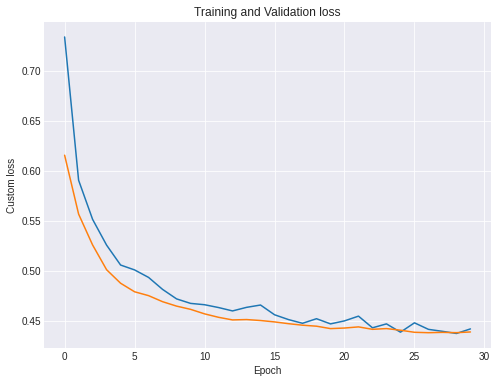

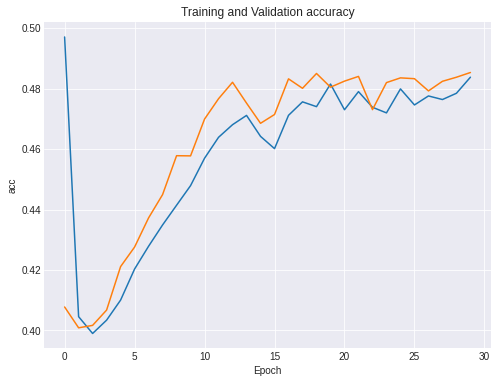

In [20]:
tf.random.set_seed(
    94
)

def nn_classifier(n_features,theta):
    inputs = Input(shape=(n_features,))
    dense1 = Dense(32, activation='relu')(inputs)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(32, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    dense3 = Dense(32, activation="relu")(dropout2)
    dropout3 = Dropout(0.2)(dense3)
    outputs = Dense(1, activation='sigmoid')(dropout3)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(loss=custom_loss(theta), optimizer='adam', metrics=tf.keras.metrics.BinaryAccuracy(
    name='acc', dtype=None, threshold=0.5))
    return model

# initialise NeuralNet Classifier
factor = 1
clf = nn_classifier(n_features=X_train.shape[1], theta=(0.43*factor, 0.2*factor))

# train on train set
Y = np.append(
    np.reshape(y_train.values, (y_train.shape[0],1)), 
    Z_train.values, axis=1
    )

Y_val = np.append(
    np.reshape(y_test.values, (y_test.shape[0],1)),
    Z_test.values, axis=1
    )

history = clf.fit(X_train.values, Y, epochs=30, verbose=1, batch_size=1024, shuffle=True, validation_data = (X_test.values, Y_val))
hist = history.history
plt.figure(figsize=(8,6))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.ylabel("Custom loss")
plt.xlabel("Epoch")
plt.title("Training and Validation loss")
plt.figure(figsize=(8,6))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.ylabel("acc")
plt.xlabel("Epoch")
plt.title("Training and Validation accuracy")

In [21]:
# predict on test set
y_pred = pd.Series(clf.predict(X_test.values).ravel(), index=y_test.index)
score_report(y_pred, y_test)
        
        

ROC AUC: 0.85
Basline Accuracy: 75.7%
Accuracy: 82.3%
Precision: 71.4%
Recall: 45.3%
Classification reports per protected Attribute:

           Protected class == race
                      Subclass==0

Accuracy: 86.3%
Precision: 44.6%
Recall: 37.2%
Sampels: 619 - Positives: 65 - Correct positives: 29
Positive rate: 10.5%
                      Subclass==1

Accuracy: 81.9%
Precision: 73.4%
Recall: 45.7%
Sampels: 5569 - Positives: 887 - Correct positives: 651
Positive rate: 15.9%

           Protected class == sex
                      Subclass==0

Accuracy: 89.7%
Precision: 48.1%
Recall: 68.9%
Sampels: 2112 - Positives: 295 - Correct positives: 142
Positive rate: 14.0%
                      Subclass==1

Accuracy: 78.5%
Precision: 81.9%
Recall: 41.5%
Sampels: 4076 - Positives: 657 - Correct positives: 538
Positive rate: 16.1%


The classifier satisfies the following %p-rules:
	given attribute race; 66%-rule
	given attribute sex;  87%-rule


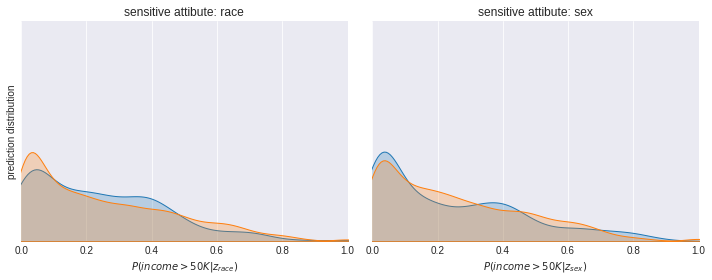

In [22]:
fig = plot_distributions(y_pred, Z_test)
print("The classifier satisfies the following %p-rules:")
print(f"\tgiven attribute race; {p_rule(y_pred, Z_test['race']):.0f}%-rule")
print(f"\tgiven attribute sex;  {p_rule(y_pred, Z_test['sex']):.0f}%-rule")

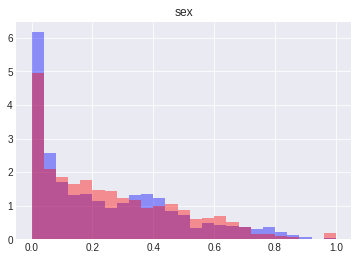

0.11115101454480159
0.5181550539744848


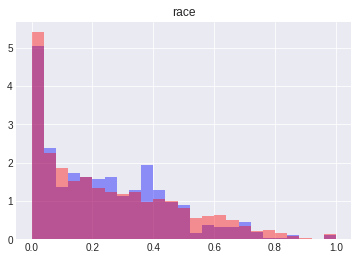

In [23]:
title="sex"
plt.title(title)
plt.hist(y_pred[Z_test[title]==0],25,(0,1),alpha=0.4,color="b",density=1)
plt.hist(y_pred[Z_test[title]==1],25,(0,1),alpha=0.4,color="r",density=1)
plt.show()
title="race"
plt.title(title)
plt.hist(y_pred[Z_test[title]==0],25,(0,1),alpha=0.4,color="b",density=1)
plt.hist(y_pred[Z_test[title]==1],25,(0,1),alpha=0.4,color="r",density=1)
print(len(y_pred[Z_test["race"]==0])/len(y_pred[Z_test["race"]==1]))
print(len(y_pred[Z_test["sex"]==0])/len(y_pred[Z_test["sex"]==1]))

In [24]:
print("The classifier sattisfies the following equalized odds epsilon:")
print(f"\tgiven attribute race; {equalized_odds(y_pred, y_test, Z_test['race']):.1f}%")
print(f"\tgiven attribute sex;  {equalized_odds(y_pred, y_test, Z_test['sex']):.1f}%")

The classifier sattisfies the following equalized odds epsilon:
	given attribute race; 8.6%
	given attribute sex;  27.4%


## Improved DI fairness, at decreased EO fairness, yet very unstable
We observe that the KDE distributions have flattened out and the fiarness metrics for race and sex have both improved significantly. This happens at the expense of the model performance, as the AOC score has dropped with regards the the baseline network, as well as the accuracy. The equalized odds epsilon has decreased, especially for the "sex" attribute

In comparisson to the Adverserial network this method is a lot faster, and can be initialised from an untrained network. But it is also very unstable as the loss function is not at all convex. If one tweaks the parameters ever so slightly the results can be dramatically different.

## BCE + Disparate Impact network 2: Regular training followed by modified loss function

Epoch 1/30
25/25 [==============================] - 0s 5ms/step - loss: 0.7904 - val_loss: 0.5812
Epoch 2/30
25/25 [==============================] - 0s 3ms/step - loss: 0.5656 - val_loss: 0.4765
Epoch 3/30
25/25 [==============================] - 0s 3ms/step - loss: 0.4796 - val_loss: 0.4044
Epoch 4/30
25/25 [==============================] - 0s 3ms/step - loss: 0.4294 - val_loss: 0.3685
Epoch 5/30
25/25 [==============================] - 0s 3ms/step - loss: 0.3950 - val_loss: 0.3538
Epoch 6/30
25/25 [==============================] - 0s 2ms/step - loss: 0.3824 - val_loss: 0.3456
Epoch 7/30
25/25 [==============================] - 0s 3ms/step - loss: 0.3779 - val_loss: 0.3411
Epoch 8/30
25/25 [==============================] - 0s 3ms/step - loss: 0.3697 - val_loss: 0.3360
Epoch 9/30
25/25 [==============================] - 0s 3ms/step - loss: 0.3615 - val_loss: 0.3324
Epoch 10/30
25/25 [==============================] - 0s 3ms/step - loss: 0.3567 - val_loss: 0.3295
Epoch 11/30
25/25 [

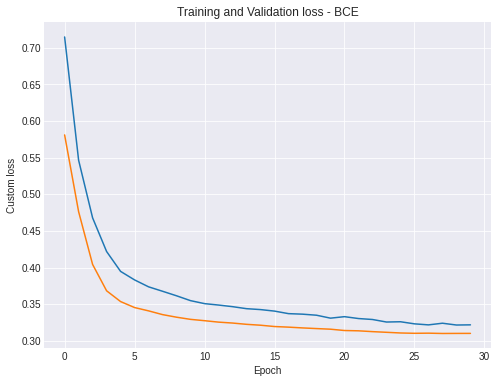

In [25]:
tf.random.set_seed(
    94
)
def nn_classifier_bce(n_features):
    inputs = Input(shape=(n_features,))
    dense1 = Dense(32, activation='relu')(inputs)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(32, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    dense3 = Dense(32, activation="relu")(dropout2)
    dropout3 = Dropout(0.2)(dense3)
    outputs = Dense(1, activation='sigmoid')(dropout3)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

def nn_classifier_mod(n_features, theta, learning_rate=0.001):
    inputs = Input(shape=(n_features,))
    dense1 = Dense(32, activation='relu')(inputs)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(32, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    dense3 = Dense(32, activation="relu")(dropout2)
    dropout3 = Dropout(0.2)(dense3)
    outputs = Dense(1, activation='sigmoid')(dropout3)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(loss=custom_loss(theta), optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=tf.keras.metrics.BinaryAccuracy(name='acc', 
                                                          dtype=None, threshold=0.5
                                                         )
                 )
    return model

# initialise BCE NeuralNet Classifier
clf_bce = nn_classifier_bce(n_features=X_train.shape[1])

# train on train set
Y = np.append(
    np.reshape(y_train.values, (y_train.shape[0],1)), 
    Z_train.values, axis=1
    )

Y_val = np.append(
    np.reshape(y_test.values, (y_test.shape[0],1)),
    Z_test.values, axis=1
    )

history = clf_bce.fit(X_train.values, y_train.values, epochs=30, verbose=1, batch_size=1024, shuffle=True, validation_data = (X_test.values, y_test.values))
hist = history.history
plt.figure(figsize=(8,6))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.ylabel("Custom loss")
plt.xlabel("Epoch")
plt.title("Training and Validation loss - BCE")


#Tensorflow does not allow dynamic changes of the loss function, we circumvent this
#by saving and loading the weights from the first network into the new network
weights = clf_bce.get_weights()

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
25/25 [==============================] - 1s 8ms/step - loss: 0.6985 - acc: 0.5289 - val_loss: 0.6502 - val_acc: 0.5362
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6673 - acc: 0.5366 - val_loss: 0.6253 - val_acc: 0.5337
Epoch 3/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6299 - acc: 0.5326 - val_loss: 0.6018 - val_acc: 0.5297
Epoch 4/50

No handles with labels found to put in legend.


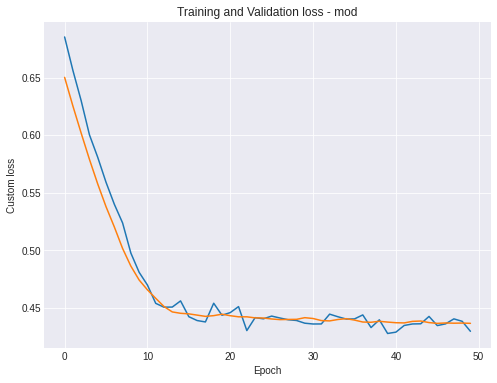

In [26]:
#Net Network with modified loss
factor = 1.2
learning_rate = 0.0002
clf_mod = nn_classifier_mod(n_features=X_train.shape[1], theta=(0.43*factor, 0.2*factor), learning_rate=learning_rate)
clf_mod.set_weights(weights)

history = clf_mod.fit(X_train.values, Y, epochs=50, verbose=1, batch_size=1024, shuffle=True, validation_data = (X_test.values, Y_val))
hist = history.history
plt.figure(figsize=(8,6))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.ylabel("Custom loss")
plt.xlabel("Epoch")
plt.title("Training and Validation loss - mod")
plt.legend()

In [27]:
# predict on test set
y_pred = pd.Series(clf_mod.predict(X_test.values).ravel(), index=y_test.index)
score_report(y_pred, y_test)
        
        

ROC AUC: 0.85
Basline Accuracy: 75.7%
Accuracy: 81.7%
Precision: 71.0%
Recall: 41.5%
Classification reports per protected Attribute:

           Protected class == race
                      Subclass==0

Accuracy: 86.3%
Precision: 45.5%
Recall: 44.9%
Sampels: 619 - Positives: 77 - Correct positives: 35
Positive rate: 12.4%
                      Subclass==1

Accuracy: 81.2%
Precision: 73.4%
Recall: 41.3%
Sampels: 5569 - Positives: 801 - Correct positives: 588
Positive rate: 14.4%

           Protected class == sex
                      Subclass==0

Accuracy: 89.1%
Precision: 46.2%
Recall: 73.3%
Sampels: 2112 - Positives: 327 - Correct positives: 151
Positive rate: 15.5%
                      Subclass==1

Accuracy: 77.9%
Precision: 85.7%
Recall: 36.4%
Sampels: 4076 - Positives: 551 - Correct positives: 472
Positive rate: 13.5%


The classifier satisfies the following %p-rules:
	given attribute race; 86%-rule
	given attribute sex;  87%-rule


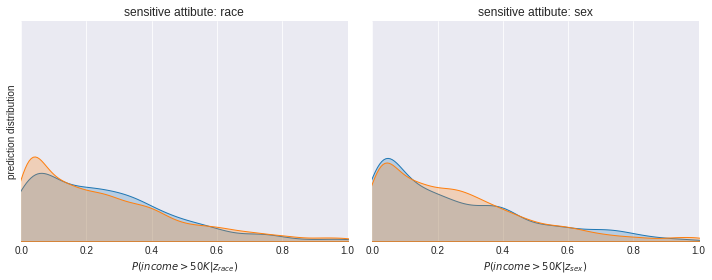

In [28]:
fig = plot_distributions(y_pred, Z_test)
print("The classifier satisfies the following %p-rules:")
print(f"\tgiven attribute race; {p_rule(y_pred, Z_test['race']):.0f}%-rule")
print(f"\tgiven attribute sex;  {p_rule(y_pred, Z_test['sex']):.0f}%-rule")

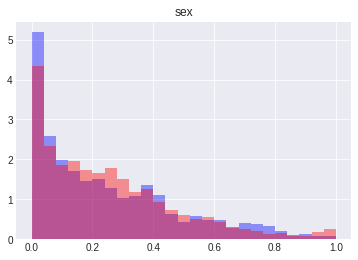

0.11115101454480159
0.5181550539744848


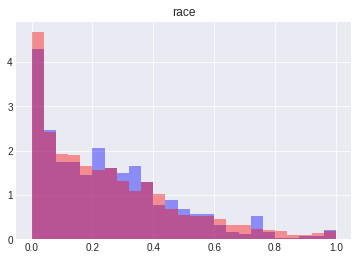

In [29]:
title="sex"
plt.title(title)
plt.hist(y_pred[Z_test[title]==0],25,(0,1),alpha=0.4,color="b",density=1)
plt.hist(y_pred[Z_test[title]==1],25,(0,1),alpha=0.4,color="r",density=1)
plt.show()
title="race"
plt.title(title)
plt.hist(y_pred[Z_test[title]==0],25,(0,1),alpha=0.4,color="b",density=1)
plt.hist(y_pred[Z_test[title]==1],25,(0,1),alpha=0.4,color="r",density=1)
print(len(y_pred[Z_test["race"]==0])/len(y_pred[Z_test["race"]==1]))
print(len(y_pred[Z_test["sex"]==0])/len(y_pred[Z_test["sex"]==1]))

In [30]:
print("The classifier sattisfies the following equalized odds epsilon:")
print(f"\tgiven attribute race; {equalized_odds(y_pred, y_test, Z_test['race']):.1f}%")
print(f"\tgiven attribute sex;  {equalized_odds(y_pred, y_test, Z_test['sex']):.1f}%")

The classifier sattisfies the following equalized odds epsilon:
	given attribute race; 3.6%
	given attribute sex;  36.9%


# Performance and Fairness 3 - BCE + Demographic Parity network

In [31]:
1-y_test.sum()/len(y_test)

0.7574337427278603

Another cost function, this time based on the demographic parity, which is very similair to the desparate impact.

In [32]:
bce = tf.keras.losses.BinaryCrossentropy()

def parity_loss(theta):
    """
    Using this wrapper to return the internal loss function allows for easy editing of 
    the otherwise high level Keras/Tensorflow model fitting objects, which expect to pass only (y_true, y_pred)
    
    Parameters
    ----------
    Theta - tuple
        weights of the DI_loss factors in the combined loss function
    """
    def DP_loss_z(y_true, y_pred, z):
        """
        Custom loss function based on the p-% rule indirectly, uses P(Y|Z)
        """
        y_pred_1, y_pred_0 = y_pred*z, y_pred*(1-z)
        custom_loss = tf.norm(tf.reduce_mean(y_pred_1) - tf.reduce_sum(z)/tf.reduce_sum((1-z))*tf.reduce_mean(y_pred_0))
        return custom_loss
    
    def final_loss(y, y_pred):
        y_true, z_race, z_sex = y[:,0], y[:,1], y[:,2]
        y_pred = tf.transpose(y_pred)
        return theta[0]*bce(y_true, y_pred) + theta[1]*DP_loss_z(y_true, y_pred,z_race) + theta[2]*DP_loss_z(y_true, y_pred, z_sex)
    return final_loss

Epoch 1/60
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
25/25 [==============================] - 1s 7ms/step - loss: 0.8346 - acc: 0.5397 - val_loss: 0.6398 - val_acc: 0.4113
Epoch 2/60
25/25 [==============================] - 0s 4ms/step - loss: 0.6229 - acc: 0.4114 - val_loss: 0.5811 - val_acc: 0.4006
Epoch 3/60
25/25 [==============================] - 0s 4ms/step - loss: 0.5740 - acc: 0.3956 - val_loss: 0.5444 - val_acc: 0.3999
Epoch 4/60

25/25 [==============================] - 0s 4ms/step - loss: 0.4388 - acc: 0.4695 - val_loss: 0.4329 - val_acc: 0.4730
Epoch 58/60
25/25 [==============================] - 0s 4ms/step - loss: 0.4207 - acc: 0.4757 - val_loss: 0.4326 - val_acc: 0.4752
Epoch 59/60
25/25 [==============================] - 0s 4ms/step - loss: 0.4286 - acc: 0.4678 - val_loss: 0.4316 - val_acc: 0.4697
Epoch 60/60
25/25 [==============================] - 0s 3ms/step - loss: 0.4261 - acc: 0.4658 - val_loss: 0.4309 - val_acc: 0.4716


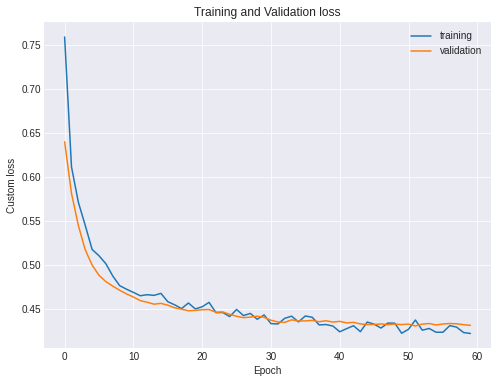

In [33]:
tf.random.set_seed(
    94
)

def nn_classifier(n_features,theta):
    inputs = Input(shape=(n_features,))
    dense1 = Dense(32, activation='relu')(inputs)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(32, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    dense3 = Dense(32, activation="relu")(dropout2)
    dropout3 = Dropout(0.2)(dense3)
    outputs = Dense(1, activation='sigmoid')(dropout3)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(loss=parity_loss(theta), optimizer='adam',metrics=tf.keras.metrics.BinaryAccuracy(
    name='acc', dtype=None, threshold=0.5))
    return model

# initialise NeuralNet Classifier
factor=1
clf = nn_classifier(n_features=X_train.shape[1],theta=(1, factor*2,factor*1))

# train on train set
Y = np.append(
    np.reshape(y_train.values, (y_train.shape[0],1)), 
    Z_train.values, axis=1
    )
Y_val = np.append(
    np.reshape(y_test.values, (y_test.shape[0],1)),
    Z_test.values, axis=1
    )

history = clf.fit(X_train.values, Y, epochs=60, verbose=1, batch_size=1024, shuffle=True, validation_data = (X_test.values, Y_val))
hist = history.history
plt.figure(figsize=(8,6))
plt.plot(hist["loss"], label="training")
plt.plot(hist["val_loss"], label="validation")
plt.ylabel("Custom loss")
plt.xlabel("Epoch")
plt.title("Training and Validation loss")
plt.legend()

In [34]:
# predict on test set
y_pred = pd.Series(clf.predict(X_test.values).ravel(), index=y_test.index)
score_report(y_pred, y_test)

ROC AUC: 0.86
Basline Accuracy: 75.7%
Accuracy: 82.3%
Precision: 76.4%
Recall: 39.1%
Classification reports per protected Attribute:

           Protected class == race
                      Subclass==0

Accuracy: 88.9%
Precision: 59.6%
Recall: 35.9%
Sampels: 619 - Positives: 47 - Correct positives: 28
Positive rate: 7.6%
                      Subclass==1

Accuracy: 81.6%
Precision: 77.5%
Recall: 39.3%
Sampels: 5569 - Positives: 721 - Correct positives: 559
Positive rate: 12.9%

           Protected class == sex
                      Subclass==0

Accuracy: 91.3%
Precision: 54.3%
Recall: 67.5%
Sampels: 2112 - Positives: 256 - Correct positives: 139
Positive rate: 12.1%
                      Subclass==1

Accuracy: 77.6%
Precision: 87.5%
Recall: 34.6%
Sampels: 4076 - Positives: 512 - Correct positives: 448
Positive rate: 12.6%


The classifier satisfies the following %p-rules:
	given attribute race; 59%-rule
	given attribute sex;  96%-rule


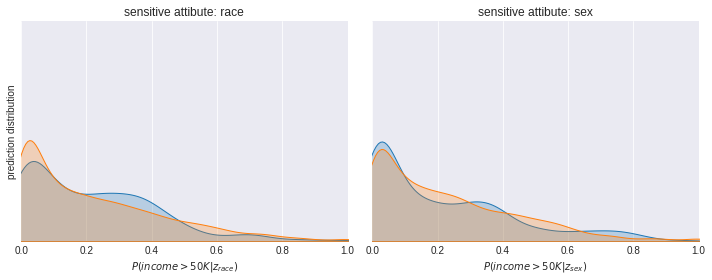

In [35]:
fig = plot_distributions(y_pred, Z_test)
print("The classifier satisfies the following %p-rules:")
print(f"\tgiven attribute race; {p_rule(y_pred, Z_test['race']):.0f}%-rule")
print(f"\tgiven attribute sex;  {p_rule(y_pred, Z_test['sex']):.0f}%-rule")

In [36]:
print("The classifier sattisfies the following equalized odds epsilon:")
print(f"\tgiven attribute race; {equalized_odds(y_pred, y_test, Z_test['race']):.1f}%")
print(f"\tgiven attribute sex;  {equalized_odds(y_pred, y_test, Z_test['sex']):.1f}%")

The classifier sattisfies the following equalized odds epsilon:
	given attribute race; 3.4%
	given attribute sex;  32.9%


## BCE + Demographic parity network 2: Regular training followed by modified loss function

Epoch 1/130
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
25/25 [==============================] - 1s 8ms/step - loss: 0.4855 - acc: 0.5278 - val_loss: 0.4608 - val_acc: 0.5336
Epoch 2/130
25/25 [==============================] - 0s 3ms/step - loss: 0.4826 - acc: 0.5326 - val_loss: 0.4583 - val_acc: 0.5308
Epoch 3/130
25/25 [==============================] - 0s 4ms/step - loss: 0.4734 - acc: 0.5280 - val_loss: 0.4562 - val_acc: 0.5278
Epoch 4

25/25 [==============================] - 0s 3ms/step - loss: 0.4196 - acc: 0.4817 - val_loss: 0.4136 - val_acc: 0.4783
Epoch 57/130
25/25 [==============================] - 0s 3ms/step - loss: 0.4214 - acc: 0.4807 - val_loss: 0.4130 - val_acc: 0.4780
Epoch 58/130
25/25 [==============================] - 0s 3ms/step - loss: 0.4140 - acc: 0.4828 - val_loss: 0.4124 - val_acc: 0.4780
Epoch 59/130
25/25 [==============================] - 0s 3ms/step - loss: 0.4210 - acc: 0.4763 - val_loss: 0.4117 - val_acc: 0.4775
Epoch 60/130
25/25 [==============================] - 0s 3ms/step - loss: 0.4209 - acc: 0.4788 - val_loss: 0.4110 - val_acc: 0.4774
Epoch 61/130
25/25 [==============================] - 0s 3ms/step - loss: 0.4093 - acc: 0.4794 - val_loss: 0.4107 - val_acc: 0.4768
Epoch 62/130
25/25 [==============================] - 0s 3ms/step - loss: 0.4206 - acc: 0.4808 - val_loss: 0.4103 - val_acc: 0.4765
Epoch 63/130
25/25 [==============================] - 0s 3ms/step - loss: 0.4140 - acc: 0

25/25 [==============================] - 0s 3ms/step - loss: 0.4000 - acc: 0.4776 - val_loss: 0.4048 - val_acc: 0.4747
Epoch 119/130
25/25 [==============================] - 0s 3ms/step - loss: 0.3986 - acc: 0.4782 - val_loss: 0.4048 - val_acc: 0.4746
Epoch 120/130
25/25 [==============================] - 0s 3ms/step - loss: 0.4011 - acc: 0.4774 - val_loss: 0.4048 - val_acc: 0.4748
Epoch 121/130
25/25 [==============================] - 0s 4ms/step - loss: 0.4017 - acc: 0.4766 - val_loss: 0.4047 - val_acc: 0.4744
Epoch 122/130
25/25 [==============================] - 0s 3ms/step - loss: 0.4061 - acc: 0.4768 - val_loss: 0.4047 - val_acc: 0.4746
Epoch 123/130
25/25 [==============================] - 0s 3ms/step - loss: 0.4105 - acc: 0.4791 - val_loss: 0.4047 - val_acc: 0.4745
Epoch 124/130
25/25 [==============================] - 0s 3ms/step - loss: 0.4055 - acc: 0.4781 - val_loss: 0.4046 - val_acc: 0.4750
Epoch 125/130
25/25 [==============================] - 0s 3ms/step - loss: 0.4006 -

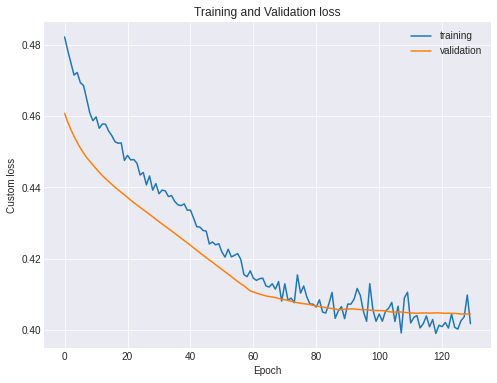

In [37]:
def nn_classifier(n_features, theta, lr=0.001):
    inputs = Input(shape=(n_features,))
    dense1 = Dense(32, activation='relu')(inputs)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(32, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    dense3 = Dense(32, activation="relu")(dropout2)
    dropout3 = Dropout(0.2)(dense3)
    outputs = Dense(1, activation='sigmoid')(dropout3)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(loss=parity_loss(theta), optimizer=tf.keras.optimizers.Adam(learning_rate=lr),metrics=tf.keras.metrics.BinaryAccuracy(
    name='acc', dtype=None, threshold=0.5))
    return model

factor=0.5
lr=0.00004
clf = nn_classifier(n_features=X_train.shape[1],theta=(1,factor*2,factor*1),lr=lr)

# train on train set
Y = np.append(
    np.reshape(y_train.values, (y_train.shape[0],1)), 
    Z_train.values, axis=1
    )
Y_val = np.append(
    np.reshape(y_test.values, (y_test.shape[0],1)),
    Z_test.values, axis=1
    )


clf.set_weights(weights)
history = clf.fit(X_train.values, Y, epochs=130, verbose=1, batch_size=1024, shuffle=True, validation_data = (X_test.values, Y_val))
hist = history.history
plt.figure(figsize=(8,6))
plt.plot(hist["loss"], label="training")
plt.plot(hist["val_loss"], label="validation")
plt.ylabel("Custom loss")
plt.xlabel("Epoch")
plt.title("Training and Validation loss")
plt.legend()

In [38]:
# predict on test set
y_pred_best_p_rule = pd.Series(clf.predict(X_test.values).ravel(), index=y_test.index)
score_report(y_pred_best_p_rule, y_test)

ROC AUC: 0.87
Basline Accuracy: 75.7%
Accuracy: 82.1%
Precision: 72.8%
Recall: 41.8%
Classification reports per protected Attribute:

           Protected class == race
                      Subclass==0

Accuracy: 85.3%
Precision: 42.0%
Recall: 43.6%
Sampels: 619 - Positives: 81 - Correct positives: 34
Positive rate: 13.1%
                      Subclass==1

Accuracy: 81.7%
Precision: 76.0%
Recall: 41.7%
Sampels: 5569 - Positives: 782 - Correct positives: 594
Positive rate: 14.0%

           Protected class == sex
                      Subclass==0

Accuracy: 90.3%
Precision: 50.2%
Recall: 68.9%
Sampels: 2112 - Positives: 283 - Correct positives: 142
Positive rate: 13.4%
                      Subclass==1

Accuracy: 77.8%
Precision: 83.8%
Recall: 37.5%
Sampels: 4076 - Positives: 580 - Correct positives: 486
Positive rate: 14.2%


The classifier satisfies the following %p-rules:
	given attribute race; 93%-rule
	given attribute sex;  94%-rule


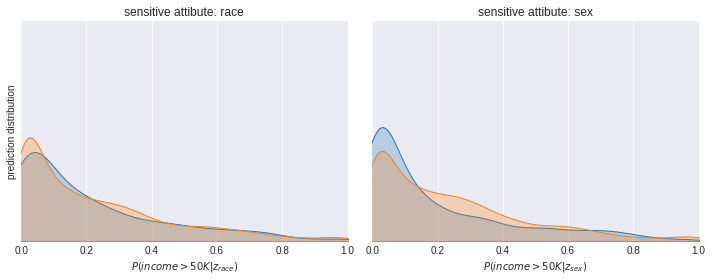

In [39]:
fig = plot_distributions(y_pred_best_p_rule, Z_test)
print("The classifier satisfies the following %p-rules:")
print(f"\tgiven attribute race; {p_rule(y_pred_best_p_rule, Z_test['race']):.0f}%-rule")
print(f"\tgiven attribute sex;  {p_rule(y_pred_best_p_rule, Z_test['sex']):.0f}%-rule")

In [40]:
print("The classifier sattisfies the following equalized odds epsilon:")
print(f"\tgiven attribute race; {equalized_odds(y_pred_best_p_rule, y_test, Z_test['race']):.1f}%")
print(f"\tgiven attribute sex;  {equalized_odds(y_pred_best_p_rule, y_test, Z_test['sex']):.1f}%")

The classifier sattisfies the following equalized odds epsilon:
	given attribute race; 4.2%
	given attribute sex;  31.4%


# Equal odds cost function

In [41]:
bce = tf.keras.losses.BinaryCrossentropy()

def custom_EO_loss(theta):
    """
    Using this wrapper to return the internal loss function allows for easy editing of 
    the otherwise high level Keras/Tensorflow model fitting objects, which expect to pass only (y_true, y_pred)
    
    Parameters
    ----------
    Theta - tuple
        weights of the EO_loss factors in the combined loss function
    """
    
    def EO_loss_z(y_true, y_pred, z):
        """
        Implementation of the Disparate Impact
        DI is an maximazation metric bounded on [0,1], thus this is easily turned into 
        a minimization problem by taking '1 - DI'  
        """
            
        def TPR(true, predicted):
            """
            Masking is not differentiable
            We circumvent this by using a sigmoid and mulitplications only
            """
            predicted = tf.math.sigmoid((predicted - 0.5) * 50)
            tp = tf.reduce_sum(true*predicted)
            p = tf.reduce_sum(true)
            tpr =  tp/(p+tf.keras.backend.epsilon()) #TP/Positives
            return tpr
                
        def FPR(true, predicted):
            """
            Masking is not differentiable
            We circumvent this by using a sigmoid and mulitplications only
            """
            predicted = tf.math.sigmoid((predicted - 0.5) * 50)
            fp = tf.reduce_sum(predicted*(1-true))
            n = tf.reduce_sum(1 - true)
            fpr = fp/(n+tf.keras.backend.epsilon()) #FP/Negatives 
            return fpr
        
        y_pred_z_1 = y_pred*z
        y_pred_z_0 = y_pred*(1.0 - z)
        
        y_true_z_1  = y_true*z
        y_true_z_0 = y_true*(1.0 - z) 
        
        epsilon_TPR = tf.norm(TPR(y_true_z_1, y_pred_z_1) - TPR(y_true_z_0, y_pred_z_0))
        epsilon_FPR = tf.norm(FPR(y_true_z_1, y_pred_z_1) - FPR(y_true_z_0, y_pred_z_0))
        loss = tf.maximum(epsilon_TPR, epsilon_FPR)
        return loss
    
    def final_loss(y, y_pred):
        y_true, z_race, z_sex = y[:,0], y[:,1], y[:,2]
        y_pred = tf.transpose(y_pred)
        return bce(y_true, y_pred) + theta[0]*EO_loss_z(y_true, y_pred, z_race) + theta[1]*EO_loss_z(y_true, y_pred, z_sex)
    return final_loss

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
25/25 [==============================] - 1s 10ms/step - loss: 2.2573 - acc: 0.5267 - val_loss: 2.4949 - val_acc: 0.5331
Epoch 2/30
25/25 [==============================] - 0s 4ms/step - loss: 2.7775 - acc: 0.5305 - val_loss: 2.4767 - val_acc: 0.5291
Epoch 3/30
25/25 [==============================] - 0s 4ms/step - loss: 2.4237 - acc: 0.5262 - val_loss: 2.3866 - val_acc: 0.5199
Epoch 4/3

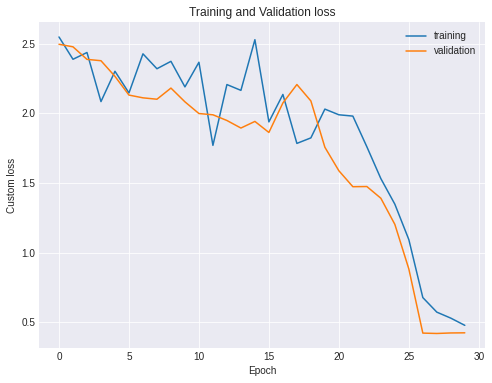

In [42]:
tf.random.set_seed(
    94
)

def nn_classifier(n_features, theta, lr=0.001):
    inputs = Input(shape=(n_features,))
    dense1 = Dense(32, activation='relu')(inputs)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(32, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    dense3 = Dense(32, activation="relu")(dropout2)
    dropout3 = Dropout(0.2)(dense3)
    outputs = Dense(1, activation='sigmoid')(dropout3)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(loss=custom_EO_loss(theta), optimizer=tf.keras.optimizers.Adam(learning_rate=lr),metrics=tf.keras.metrics.BinaryAccuracy(
    name='acc', dtype=None, threshold=0.5))
    return model

factor=10
lr=0.0005
clf = nn_classifier(n_features=X_train.shape[1],theta=(factor*1,factor*1),lr=lr)

# train on train set
Y = np.append(
    np.reshape(y_train.values, (y_train.shape[0],1)),
    Z_train.values, axis=1
    )

Y_val = np.append(
    np.reshape(y_test.values, (y_test.shape[0],1)),
    Z_test.values, axis=1
    )

clf.set_weights(weights)
history = clf.fit(X_train.values, Y, epochs=30, verbose=1, batch_size=1024, shuffle=True, validation_data = (X_test.values, Y_val))
hist = history.history
plt.figure(figsize=(8,6))
plt.plot(hist["loss"], label = "training")
plt.plot(hist["val_loss"], label = "validation")
plt.ylabel("Custom loss")
plt.xlabel("Epoch")
plt.title("Training and Validation loss")
plt.legend()

In [43]:
# predict on test set
y_pred = pd.Series(clf.predict(X_test.values).ravel(), index=y_test.index)
score_report(y_pred, y_test)

ROC AUC: 0.89
Basline Accuracy: 75.7%
Accuracy: 75.7%
Precision: 0.0%
Recall: 0.0%
Classification reports per protected Attribute:

           Protected class == race
                      Subclass==0

Accuracy: 87.4%
Precision: 0.0%
Recall: 0.0%
Sampels: 619 - Positives: 0 - Correct positives: 0
Positive rate: 0.0%
                      Subclass==1

Accuracy: 74.4%
Precision: 0.0%
Recall: 0.0%
Sampels: 5569 - Positives: 0 - Correct positives: 0
Positive rate: 0.0%

           Protected class == sex
                      Subclass==0

Accuracy: 90.2%
Precision: 0.0%
Recall: 0.0%
Sampels: 2112 - Positives: 0 - Correct positives: 0
Positive rate: 0.0%
                      Subclass==1

Accuracy: 68.2%
Precision: 0.0%
Recall: 0.0%
Sampels: 4076 - Positives: 0 - Correct positives: 0
Positive rate: 0.0%


/home/alex/anaconda3/envs/FairAlgorithms/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alex/anaconda3/envs/FairAlgorithms/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alex/anaconda3/envs/FairAlgorithms/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alex/anaconda3/envs/FairAlgorithms

The classifier satisfies the following %p-rules:
	given attribute race; nan%-rule
	given attribute sex;  nan%-rule


<ipython-input-13-d92a32b06d46>:4: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()
<ipython-input-13-d92a32b06d46>:4: RuntimeWarning: invalid value encountered in double_scalars
  odds = y_z_1.mean() / y_z_0.mean()


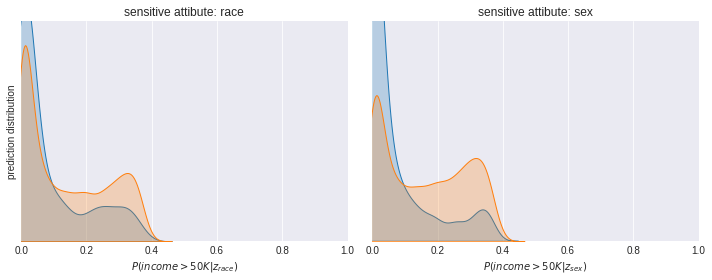

In [44]:
fig = plot_distributions(y_pred, Z_test)
print("The classifier satisfies the following %p-rules:")
print(f"\tgiven attribute race; {p_rule(y_pred, Z_test['race']):.0f}%-rule")
print(f"\tgiven attribute sex;  {p_rule(y_pred, Z_test['sex']):.0f}%-rule")

In [45]:
print("The classifier sattisfies the following equalized odds epsilon:")
print(f"\tgiven attribute race; {equalized_odds(y_pred, y_test, Z_test['race']):.1f}%")
print(f"\tgiven attribute sex;  {equalized_odds(y_pred, y_test, Z_test['sex']):.1f}%")

The classifier sattisfies the following equalized odds epsilon:
	given attribute race; 0.0%
	given attribute sex;  0.0%


# Post Processing EO - Using the ROC curve and finding intersection points
As seen above, the EO loss network tends to resolve to trivial solutions very easily. Thus we try a different post-processing approach.
Using our best performing P-rule classifier, we can now optimize the EO fairness as well by finding an intersection in the ROC-curve, as an intersection in the ROC-curve per definition has equal FPR and equal TPR for both classes. This does mean that different classification thresholds are applied for both classes of a protected attribute! 

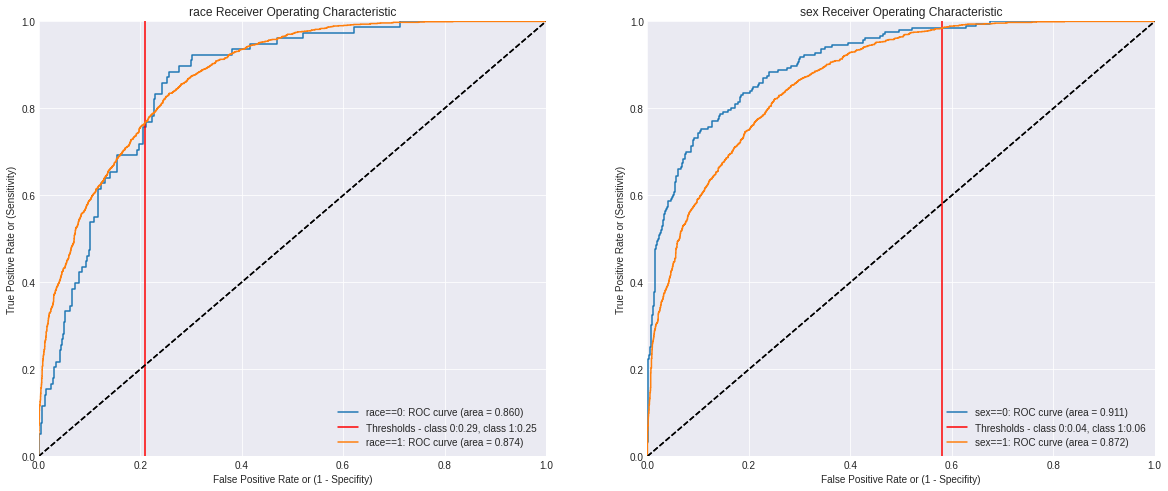

In [46]:
fprs, tprs, thresholds, roc_aucs = [], [], [], []
protected_attributes = ["race", "sex"]
subclasses = [0,1]
for i, z_att in enumerate(protected_attributes):
    for subclass in subclasses:
        mask = Z_test[z_att]==subclass
        y_t_s, y_p_s = y_test[mask], y_pred_best_p_rule[mask] 
        fpr, tpr, threshold = roc_curve(y_t_s, y_p_s)
        roc_auc = roc_auc_score(y_t_s, y_p_s)
        fprs.append(fpr)
        tprs.append(tpr)
        thresholds.append(threshold)
        roc_aucs.append(roc_auc)
z_att = ["race","race","sex","sex"]
subclass = [0,1,0,1]
eo_thresholds_race = []
eo_thresholds_sex = []
fig, ax = plt.subplots(1, len(subclasses), figsize=(10*len(subclasses),8))
for i in range(4):
    fpr, tpr, threshold, roc_auc = fprs[i], tprs[i], thresholds[i], roc_aucs[i]
    if i<2:
        plt.sca(ax[0])
    else:
        plt.sca(ax[1])
    if i==1 or i==3:
        if i==1:
            j = 0
            val = 0.21
        else:
            j = 2
            val = 0.58
        index_1 = np.argmin(np.abs(fpr-val))
        thres_1 = threshold[index_1]
        

        fpr_0 = fprs[j]
        threshold_0 = thresholds[j]
        index_0 = np.argmin(np.abs(fpr_0-val))
        thres_0 = threshold_0[index_0]
        if i==1:
            eo_threshold_race = [thres_0, thres_1]
        elif i==3:
            eo_threshold_sex = [thres_0, thres_1]
        plt.axvline(val ,c="r",label=f"Thresholds - class 0:{thres_0:.2f}, class 1:{thres_1:.2f}")
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{z_att[i]}=={subclass[i]}: ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title(f'{z_att[i]} Receiver Operating Characteristic')
    plt.legend(loc="lower right")

In [47]:
masks_race = [Z_test["race"]==1]
y_pred_eo_race = y_pred_best_p_rule.copy()
for mask in masks_race:
    subselection_1 = y_pred_eo_race[mask]
    subselection_0 = y_pred_eo_race[~mask]
    pred_0, pred_1 = subselection_0>eo_threshold_race[0], subselection_1>eo_threshold_race[1]
    y_pred_eo_race[~mask] = pred_0
    y_pred_eo_race[mask] = pred_1
           
masks_sex = [Z_test["sex"]==1]
y_pred_eo_sex= y_pred_best_p_rule.copy()
for mask in masks_sex:
    subselection_1 = y_pred_eo_sex[mask]
    subselection_0 = y_pred_eo_sex[~mask]
    pred_0, pred_1 = (subselection_0>eo_threshold_sex[0]), subselection_1>eo_threshold_sex[1]
    y_pred_eo_sex[~mask] = pred_0
    y_pred_eo_sex[mask] = pred_1


## Results when optimizing EO fairness for Race

In [48]:
# predict on test set

score_report(y_pred_eo_race, y_test)

ROC AUC: 0.78
Basline Accuracy: 75.7%
Accuracy: 78.5%
Precision: 54.0%
Recall: 76.7%
Classification reports per protected Attribute:

           Protected class == race
                      Subclass==0

Accuracy: 78.7%
Precision: 34.3%
Recall: 75.6%
Sampels: 619 - Positives: 172 - Correct positives: 59
Positive rate: 27.8%
                      Subclass==1

Accuracy: 78.5%
Precision: 55.7%
Recall: 76.7%
Sampels: 5569 - Positives: 1960 - Correct positives: 1092
Positive rate: 35.2%

           Protected class == sex
                      Subclass==0

Accuracy: 78.6%
Precision: 29.5%
Recall: 85.4%
Sampels: 2112 - Positives: 597 - Correct positives: 176
Positive rate: 28.3%
                      Subclass==1

Accuracy: 78.4%
Precision: 63.5%
Recall: 75.3%
Sampels: 4076 - Positives: 1535 - Correct positives: 975
Positive rate: 37.7%


In [49]:
#fig = plot_distributions(y_pred_eo_race, Z_test)
print("The classifier satisfies the following %p-rules:")
print(f"\tgiven attribute race; {p_rule(y_pred_eo_race, Z_test['race']):.0f}%-rule")
print(f"\tgiven attribute sex;  {p_rule(y_pred_eo_race, Z_test['sex']):.0f}%-rule")

The classifier satisfies the following %p-rules:
	given attribute race; 79%-rule
	given attribute sex;  75%-rule


In [50]:
print("The classifier sattisfies the following equalized odds epsilon:")
print(f"\tgiven attribute race; {equalized_odds(y_pred_eo_race, y_test, Z_test['race']):.1f}%")
print(f"\tgiven attribute sex;  {equalized_odds(y_pred_eo_race, y_test, Z_test['sex']):.1f}%")

The classifier sattisfies the following equalized odds epsilon:
	given attribute race; 1.1%
	given attribute sex;  10.1%


## Results when optimizing EO fairness for sex

In [51]:
# predict on test set
score_report(y_pred_eo_sex, y_test)

ROC AUC: 0.69
Basline Accuracy: 75.7%
Accuracy: 54.2%
Precision: 34.5%
Recall: 98.4%
Classification reports per protected Attribute:

           Protected class == race
                      Subclass==0

Accuracy: 44.9%
Precision: 18.3%
Recall: 97.4%
Sampels: 619 - Positives: 415 - Correct positives: 76
Positive rate: 67.0%
                      Subclass==1

Accuracy: 55.3%
Precision: 36.2%
Recall: 98.5%
Sampels: 5569 - Positives: 3870 - Correct positives: 1401
Positive rate: 69.5%

           Protected class == sex
                      Subclass==0

Accuracy: 43.2%
Precision: 14.5%
Recall: 98.5%
Sampels: 2112 - Positives: 1399 - Correct positives: 203
Positive rate: 66.2%
                      Subclass==1

Accuracy: 59.9%
Precision: 44.1%
Recall: 98.4%
Sampels: 4076 - Positives: 2886 - Correct positives: 1274
Positive rate: 70.8%


In [52]:
#fig = plot_distributions(y_pred, Z_test)
print("The classifier satisfies the following %p-rules:")
print(f"\tgiven attribute race; {p_rule(y_pred_eo_sex, Z_test['race']):.0f}%-rule")
print(f"\tgiven attribute sex;  {p_rule(y_pred_eo_sex, Z_test['sex']):.0f}%-rule")

The classifier satisfies the following %p-rules:
	given attribute race; 96%-rule
	given attribute sex;  94%-rule


In [53]:
print("The classifier sattisfies the following equalized odds epsilon:")
print(f"\tgiven attribute race; {equalized_odds(y_pred_eo_sex, y_test, Z_test['race']):.1f}%")
print(f"\tgiven attribute sex;  {equalized_odds(y_pred_eo_sex, y_test, Z_test['sex']):.1f}%")

The classifier sattisfies the following equalized odds epsilon:
	given attribute race; 3.1%
	given attribute sex;  4.8%
